In [11]:
# analyze the val2025 3d runs
import pickle 
import os
from cryofinder.analyze_search_outputs import incorporate_postfiltered, score_hits, select_best_maps
import torch

emds = [x[:-1].lower().replace('-','_') for x in open("/home/gridsan/jroney/val2025_maps.txt",'r').readlines()]
results = {}
suffix = "_search_res_rot1_trans1_extent0_hartley_3d_postfilternum64_transpf0_numtranspf1_rotpf2.pt"

for i,e in enumerate(emds):
    if os.path.exists('/home/gridsan/jroney/search_results2/' + e + suffix):
        res = torch.load('/home/gridsan/jroney/search_results2/' + e + suffix, map_location='cpu')

        for k,v in res.items():
            if k in results:
                results[k].append(v)
            else:
                results[k]  = [v]

results = {k: torch.stack(v) if (torch.is_tensor(v[0]) and k not in  ("unique_indices", "corr_pf")) else v for k,v in results.items()}

search_terms = [["doublet", "microtubule"],
                ["complex i"],
                ["apoferritin"],
                ["spike", "sars-cov-2"],
                ["nucleosome"],
                ["fof1", "atp synthase"],
                ["70s"], 
                ["cas9", "spcas9"],
                ["actin"],
                ["hiv;capsid", "hiv;hexamer"],
                ["cdc37", "hsp90"]]

all_topics = sorted(pickle.load(open("/home/gridsan/jroney/emdb_topics.pkl", 'rb')), key=lambda x:x[0])

ids_all = [int(x[:-1].split("_")[-1]) for x in open("/home/gridsan/jroney/all_ids.txt").readlines()]
topics_dict = {emd : x for emd,x in zip(ids_all, all_topics)}

# load volume data
voldata = torch.load("/home/gridsan/jroney/siren_vols.pt")

/tmp/ipykernel_276807/501317905.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load('/home/gridsan/jroney/search_results2/' + e + suffix, map_location='cpu

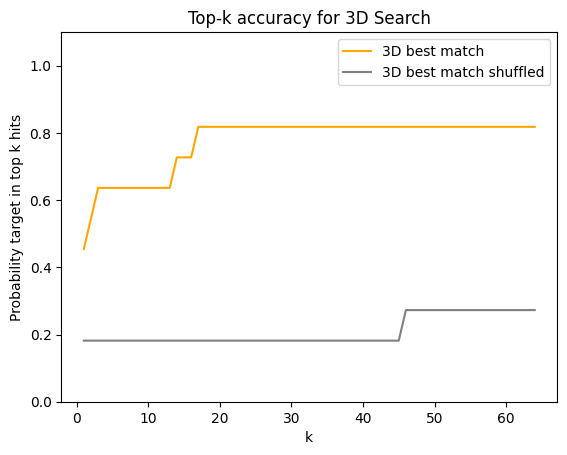

tensor(49.4545)


In [13]:
import matplotlib.pyplot as plt

maxk = 64
corr_all = results['corr'].amax(dim=(1,-1,-2))
hit_indices = corr_all.topk(maxk, dim=-1)[1]
hit_ids = voldata['ids'][hit_indices]

hit_acc = score_hits(topics_dict, hit_ids, search_terms)
cum_acc = (hit_acc.cumsum(dim=-1) > 0).to(torch.float)

def derangement(n):
    perm = torch.randperm(n)
    for i in range(n):
        if perm[i] == i:  # If an element is in its original place, swap it
            perm[i], perm[(i+1) % n] = perm[(i+1) % n], perm[i]
    return perm

hit_acc_wrong = score_hits(topics_dict, hit_ids[derangement(11)], search_terms)
cum_acc_wrong = (hit_acc_wrong.cumsum(dim=-1) > 0).to(torch.float)


plt.plot(torch.arange(cum_acc.shape[-1]) + 1, cum_acc.mean(dim=0), color="orange", label="3D best match")
plt.plot(torch.arange(cum_acc_wrong.shape[-1]) + 1, cum_acc_wrong.mean(dim=0), color="grey", label="3D best match shuffled")

plt.xlabel("k")
plt.ylabel("Probability target in top k hits")
plt.title("Top-k accuracy for 3D Search")
plt.legend(bbox_to_anchor=(1, 1))
plt.ylim(0,1.1)
plt.show()

print(cum_acc.mean(dim=0).sum(dim=-1))



(<Figure size 700x200 with 14 Axes>,
 array([[<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >],
        [<AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >, <AxesSubplot: >, <AxesSubplot: >,
         <AxesSubplot: >]], dtype=object))

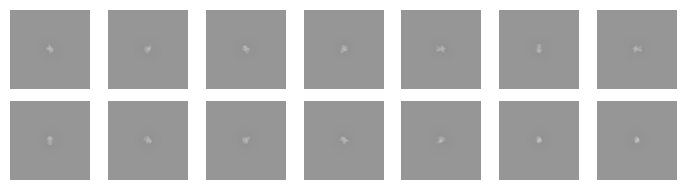

In [7]:
from cryodrgn.source import ImageSource

vos = ImageSource.from_file("../test_cases/cryosparc_P25_J411_008_volume_map.mrcs").images()
plot_projections(vos, nrows=2)

In [61]:
res = torch.load('/home/gridsan/jroney/search_results2/cryosparc_P25_J411_008_volume_map_search_res_rot1_trans1_extent0_slowrotate_hartley_postfilternum64_transpf7_numtranspf7_rotpf2.pt')
res = {k: v.unsqueeze(0) if torch.is_tensor(v) else [v] for k,v in res.items()}

/tmp/ipykernel_952848/4151852646.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res = torch.load('/home/gridsan/jroney/search_results2/cryosparc_P25_J411_008_volume_map

In [62]:
corr_all = incorporate_postfiltered(res, mean_best_projection=True)[:,:12]
bwq_indices = select_best_maps(corr_all, "worst_best")

In [63]:
matched_proj = corr_all[0][torch.arange(12).unsqueeze(1), bwq_indices].argmax(dim=-1)
matched_images = images_all_raw[bwq_indices, matched_proj]

(2362, "Here's the list of biological entities extracted from the text, following your guidelines:\n\n*   METTL1-WDR4\n*   Lys-tRNA\n*   SAM\n")


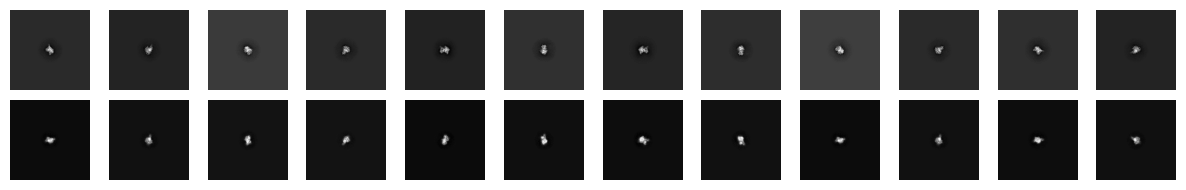

In [85]:
i = 0
plot_projections(torch.cat([vos[:12], matched_images[:,i]]), nrows=2)
print(all_topics[bwq_indices[0,i]])

In [84]:
print("\n----\n".join([all_topics[bwq_indices[0,i]][1] for i in range(64)]))

```json
[
  "GSDMB",
  "IpaH7.8",
  "shigella"
]
```

----
*   SPY
*   GPD-complex
*   GDP-fucose
*   Arabidopsis

----
Here's the list of biological entities extracted from the text, following your guidelines:

*   METTL1-WDR4
*   Lys-tRNA
*   SAM

----
*   EBNA1
*   Dyad Symmetry region
*   EBNA1 DNA binding domain
*   Dyad Symmetry element

----
['pfCSP']

----
Here's the list of biological entities extracted from the input text:

*   Dicer
*   mouse
*   pre-mir-15a
*   Mammalian Dicer
*   pre-miR-15a
----
- AtAgo10-guide RNA complex
- Arabidopsis Ago10-guide RNA complex

----
*   SPY
*   GDP-fucose
*   Arabidopsis SPY

----
```json
[
  "SPY",
  "GDP-fucose",
  "Arabidopsis SPY"
]
```
----
['Cryo-EM structure']

----
Here's the list of biological entities extracted from the text, formatted as requested:

*   nsp12
*   nsp7
*   nsp8
*   RNA
*   Porcine epidemic diarrhea virus

----
- hSERINC3-DeltaICL4-SiA
- Human SERINC3-DeltaICL4

----
- Leucine Rich Repeat Kinase 1
- LRRK1

----
[